<a href="https://colab.research.google.com/github/swilsonmfc/automl/blob/main/PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyCaret

![](https://live.staticflickr.com/5595/14331184790_cdec7bff56_n.jpg)

In [1]:
!pip install pycaret

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from pycaret.classification import * 

# Data

In [3]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/Dodgers.data -O Dodgers.data

--2021-05-12 20:10:53--  http://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/Dodgers.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 961432 (939K) [application/x-httpd-php]
Saving to: ‘Dodgers.data’

Dodgers.data        100%[===================>] 938.90K  5.54MB/s    in 0.2s    

2021-05-12 20:10:53 (5.54 MB/s) - ‘Dodgers.data’ saved [961432/961432]



In [4]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/Dodgers.events -O Dodgers.events

--2021-05-12 20:10:53--  http://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/Dodgers.events
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4140 (4.0K) [application/x-httpd-php]
Saving to: ‘Dodgers.events’

Dodgers.events      100%[===================>]   4.04K  --.-KB/s    in 0s      

2021-05-12 20:10:53 (299 MB/s) - ‘Dodgers.events’ saved [4140/4140]



# Data Prep

## Traffic

In [5]:
columns = ['observation', 'cars']
traffic_df = pd.read_csv('Dodgers.data', names=columns)
traffic_df = traffic_df.replace(-1, 0)
traffic_df['observation'] = pd.to_datetime(traffic_df.observation)
traffic_df.head()

,observation,cars
0,2005-04-10 00:00:00,0
1,2005-04-10 00:05:00,0
2,2005-04-10 00:10:00,0
3,2005-04-10 00:15:00,0
4,2005-04-10 00:20:00,0


## Events

In [6]:
columns = ['start', 'end', 'attendence', 'opponent', 'score']
events_df = pd.read_csv('Dodgers.events', engine='python', names=columns, index_col=None)
events_df['score'] = events_df.score.str[0 : -1]
events_df.head()

,start,end,attendence,opponent,score
04/12/05,13:10:00,16:23:00,55892,San Francisco,W 9-8
04/13/05,19:10:00,21:48:00,46514,San Francisco,W 4-1
04/15/05,19:40:00,21:48:00,51816,San Diego,W 4-0
04/16/05,19:10:00,21:52:00,54704,San Diego,W 8-3
04/17/05,13:10:00,15:31:00,53402,San Diego,W 6-0


In [7]:
# No events rollover dates
events_df[events_df.end.str.startswith('0')]

,start,end,attendence,opponent,score


In [8]:
events_df = events_df.reset_index()
events_df = events_df.rename(columns={'index': 'date'})
events_df['start_date'] = [' '.join([date, time]) for date, time in zip(events_df.date, events_df.start)]
events_df['start_date'] = pd.to_datetime(events_df.start_date)

events_df['end_date']   = [' '.join([date, time]) for date, time in zip(events_df.date, events_df.end)]
events_df['end_date'] = pd.to_datetime(events_df.end_date)

## Merge

In [9]:
obs   = traffic_df.observation.values
upper = events_df.end_date.values
lower = events_df.start_date.values

i, j = np.where((obs[:, None] >= lower) & (obs[:, None] <= upper))

merge_df = pd.DataFrame(
    np.column_stack([traffic_df.values[i], events_df.values[j]]),
    columns=traffic_df.columns.append(events_df.columns)
).append(
    traffic_df[~np.in1d(np.arange(len(traffic_df)), np.unique(i))],
    ignore_index=True, sort=False
)

In [10]:
# Break that np.where clause down
A = np.array([0, 1, 2, 3, 4, 5])
B = np.array([-5, 1, 3, 8])
C = np.array([-3, 2, 4, 10])
left, right = np.where((A[:, None] >= B) & (A[:, None] <= C))
print('Left Indices ', left)
print('Right Indices', right)

Left Indices  [1 2 3 4]
Right Indices [1 1 2 2]


In [11]:
merge_df['cars']   = merge_df.cars.astype(int)
merge_df['hour']   = merge_df.observation.dt.hour
merge_df['dow']    = merge_df.observation.dt.dayofweek
merge_df['month']  = merge_df.observation.dt.month
merge_df['target'] = np.where(pd.isnull(merge_df.attendence), 0, 1)

## Training

In [12]:
data_df = merge_df[['observation', 'hour', 'dow', 'month', 'cars', 'target']]
data_df

,observation,hour,dow,month,cars,target
0,2005-04-12 13:10:00,13,1,4,32,1
1,2005-04-12 13:15:00,13,1,4,38,1
2,2005-04-12 13:20:00,13,1,4,45,1
3,2005-04-12 13:25:00,13,1,4,33,1
4,2005-04-12 13:30:00,13,1,4,28,1
...,...,...,...,...,...,...
50395,2005-10-01 23:35:00,23,5,10,0,0
50396,2005-10-01 23:40:00,23,5,10,0,0
50397,2005-10-01 23:45:00,23,5,10,0,0
50398,2005-10-01 23:50:00,23,5,10,0,0


# EDA

## Target
* Data is quite imbalanced

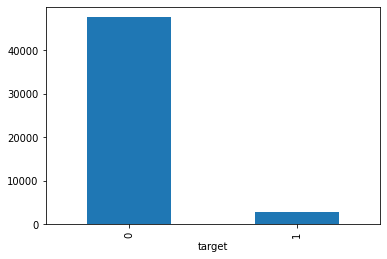

In [13]:
data_df.groupby('target').size().plot.bar()

In [14]:
weights = 1 / (data_df.groupby('target').size() / len(data_df))
weights

target
0     1.058846
1    17.993574
dtype: float64

## Hour
* Some afternoon games, but many evening games
* No morning games to speak of

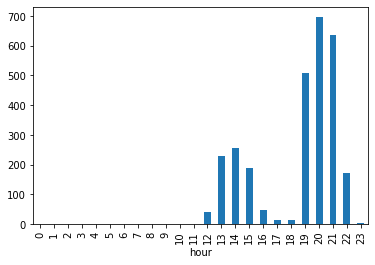

In [15]:
data_df.groupby('hour')['target'].sum().plot.bar()

## Day of Week
* Sundays and Wednesdays aren't as popular for games

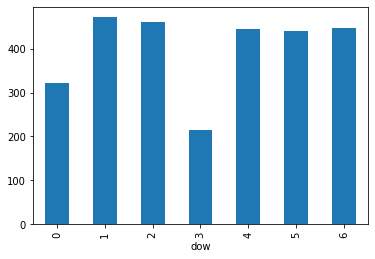

In [16]:
data_df.groupby('dow')['target'].sum().plot.bar()

## Cars

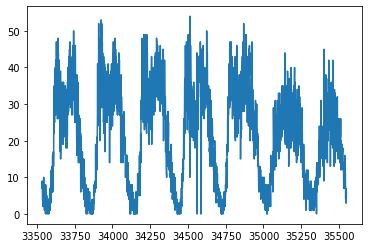

In [17]:
data_df[(data_df.observation >= '2005-08-01') & (data_df.observation < '2005-08-08')]['cars'].plot()

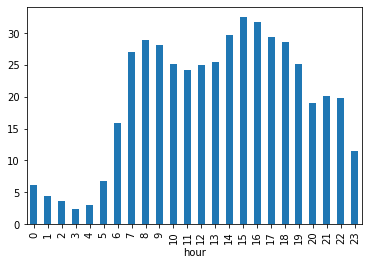

In [18]:
data_df.groupby('hour')['cars'].mean().plot.bar()

Text(0.5, 1.0, '')

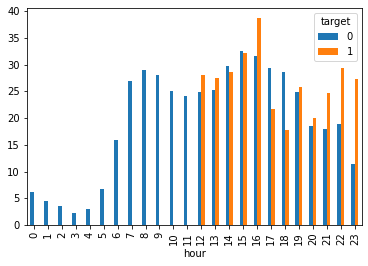

In [19]:
pd.pivot_table(data_df, values='cars', index='hour', columns='target', aggfunc=np.mean).plot.bar()
plt.title('')

# Train / Test

In [20]:
X = data_df.copy()
y = data_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, stratify=y)

In [21]:
print(y_train.sum(), y_test.sum())

2241 560


# Model

In [22]:
results_df = pd.DataFrame(columns=['F1 Score'])

## Preprocessing

In [49]:
setup(data=X, target='target', silent=True, session_id=5900)

,Description,Value
0,session_id,5900
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(50400, 6)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


(False,        hour  cars  ...  observation_hour_8  observation_hour_9
 39241  13.0  27.0  ...                 0.0                 0.0
 29632  11.0  17.0  ...                 0.0                 0.0
 14517   7.0  34.0  ...                 0.0                 0.0
 20806  17.0  40.0  ...                 0.0                 0.0
 23187  23.0   7.0  ...                 0.0                 0.0
 ...     ...   ...  ...                 ...                 ...
 5922    9.0   0.0  ...                 0.0                 1.0
 12613  23.0   7.0  ...                 0.0                 0.0
 43793   7.0  41.0  ...                 0.0                 0.0
 1901   20.0  23.0  ...                 0.0                 0.0
 44755   0.0   0.0  ...                 0.0                 0.0
 
 [35279 rows x 42 columns], 'lightgbm', None, [], {'Bagging': <pycaret.containers.models.classification.BaggingClassifierContainer at 0x7f7b1fdef190>,
  'CalibratedCV': <pycaret.containers.models.classification.CalibratedCl

## Compare

In [50]:
best = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9469,0.9441,0.4842,0.5238,0.5029,0.4749,0.4755,1.928
lightgbm,Light Gradient Boosting Machine,0.9554,0.9718,0.3944,0.6678,0.4948,0.4731,0.4917,0.307
et,Extra Trees Classifier,0.9472,0.8297,0.4531,0.5290,0.4876,0.4600,0.4618,2.162
dt,Decision Tree Classifier,0.9462,0.7792,0.4327,0.5197,0.4718,0.4437,0.4460,0.087
knn,K Neighbors Classifier,0.9461,0.8908,0.3474,0.5224,0.4166,0.3896,0.3989,0.798
lda,Linear Discriminant Analysis,0.9130,0.9117,0.4918,0.3174,0.3857,0.3412,0.3508,0.267
gbc,Gradient Boosting Classifier,0.9485,0.9564,0.1980,0.6141,0.2982,0.2788,0.3284,2.873
nb,Naive Bayes,0.6531,0.8280,0.9903,0.1373,0.2411,0.1591,0.2917,0.056
qda,Quadratic Discriminant Analysis,0.6182,0.7208,0.8362,0.1101,0.1941,0.1067,0.2055,0.123
svm,SVM - Linear Kernel,0.9387,0.0000,0.1168,0.3576,0.1434,0.1261,0.1570,0.968


## Model

In [51]:
rf = create_model('rf', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9484,0.9424,0.4541,0.5427,0.4944,0.4675,0.4696
1,0.9473,0.9308,0.4847,0.5278,0.5053,0.4775,0.4780
2,0.9439,0.9304,0.4643,0.4946,0.4789,0.4493,0.4496
3,0.9430,0.9456,0.4439,0.4860,0.4640,0.4340,0.4345
4,0.9515,0.9593,0.5204,0.5698,0.5440,0.5185,0.5191
5,0.9507,0.9432,0.5561,0.5561,0.5561,0.5300,0.5300
6,0.9487,0.9521,0.5000,0.5414,0.5199,0.4928,0.4933
7,0.9459,0.9415,0.5000,0.5131,0.5065,0.4778,0.4779
8,0.9456,0.9547,0.4388,0.5119,0.4725,0.4440,0.4455
9,0.9439,0.9415,0.4796,0.4947,0.4870,0.4574,0.4574


## Plot

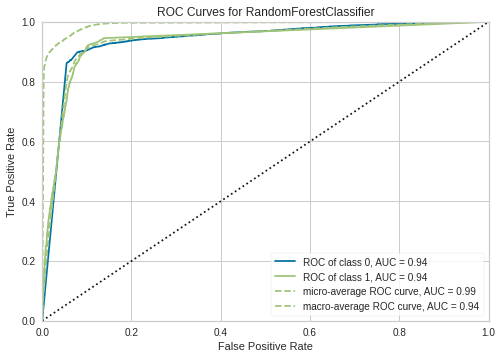

In [66]:
plot_model(rf)

In [67]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [68]:
rf_calibrated = calibrate_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9515,0.9591,0.2755,0.6506,0.3871,0.3661,0.4032
1,0.9512,0.9605,0.3622,0.6017,0.4522,0.4284,0.4435
2,0.9481,0.9519,0.3163,0.5586,0.4039,0.3790,0.3958
3,0.9442,0.9587,0.2653,0.4952,0.3455,0.3191,0.3362
4,0.9529,0.9685,0.3520,0.6389,0.4539,0.4315,0.4525
5,0.9515,0.9578,0.4031,0.5940,0.4802,0.4558,0.4652
6,0.9532,0.9618,0.3367,0.6535,0.4444,0.4226,0.4481
7,0.9504,0.9607,0.3214,0.6000,0.4186,0.3952,0.4163
8,0.9487,0.9631,0.2755,0.5806,0.3737,0.3505,0.3772
9,0.9481,0.9557,0.3316,0.5556,0.4153,0.3900,0.4043


## Threshold

### High Reward - True Positive

In [78]:
fp = 1
tp = 4
fn = 1
tn = 2
optimize_threshold(rf_calibrated, false_positive=fp, true_positive=tp, true_negative=tn, false_negative=fn)

Optimized Probability Threshold: 0.0379 | Optimized Cost Function: 30534


0.0379

### High Reward - True Negative

In [76]:
fp = 1
tp = 2
fn = 1
tn = 5
optimize_threshold(rf_calibrated, false_positive=fp, true_positive=tp, true_negative=tn, false_negative=fn)

Optimized Probability Threshold: 0.7903 | Optimized Cost Function: 72262


0.7903

## Finalize
* Use the entire training dataset to build a final model

In [71]:
rf_model = finalize_model(rf_calibrated)

## Predict
* Use the model to test performance on the holdout

In [72]:
pred = predict_model(rf_model, data=X_test)
print(classification_report(y_test, pred.Label))
results_df.loc['Random Forest'] = [f1_score(y_test, pred.Label)]

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9520
           1       0.99      0.37      0.54       560

    accuracy                           0.96     10080
   macro avg       0.98      0.69      0.76     10080
weighted avg       0.97      0.96      0.96     10080



In [73]:
pred

,observation,hour,dow,month,cars,target,Label,Score
26476,2005-07-06 03:20:00,3,2,7,0,0,0,0.9681
18919,2005-06-08 17:35:00,17,2,6,27,0,0,0.9681
30956,2005-07-22 04:20:00,4,4,7,2,0,0,0.9681
3859,2005-04-13 22:05:00,22,2,4,39,0,0,0.9679
11993,2005-05-13 12:25:00,12,4,5,23,0,0,0.9680
...,...,...,...,...,...,...,...,...
4080,2005-04-14 16:30:00,16,3,4,35,0,0,0.9681
36693,2005-08-12 08:20:00,8,4,8,33,0,0,0.9681
20316,2005-06-14 00:20:00,0,1,6,8,0,0,0.9681
21908,2005-06-19 13:00:00,13,6,6,17,0,0,0.9413


In [74]:
pred[pred.target == 1]

,observation,hour,dow,month,cars,target,Label,Score
432,2005-05-04 19:45:00,19,2,5,19,1,0,0.9153
2159,2005-08-26 22:05:00,22,4,8,37,1,1,0.5411
26,2005-04-12 15:20:00,15,1,4,40,1,0,0.8199
1499,2005-07-16 14:05:00,14,5,7,26,1,0,0.5225
1932,2005-08-12 20:40:00,20,4,8,28,1,0,0.6352
...,...,...,...,...,...,...,...,...
1193,2005-06-12 14:30:00,14,6,6,35,1,0,0.7682
1024,2005-06-06 19:10:00,19,0,6,27,1,1,0.5966
676,2005-05-20 21:00:00,21,4,5,29,1,0,0.7719
387,2005-05-02 21:50:00,21,0,5,34,1,1,0.5104


# Outperform
* Balancing Classes
* Ensembles (Blending / Stacking)

## Class Balance

In [36]:
setup(data=X, target='target', fix_imbalance=True, silent=True, session_id=5901)

,Description,Value
0,session_id,5901
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(50400, 6)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


(False,        hour  cars  ...  observation_hour_8  observation_hour_9
 36727  11.0  32.0  ...                 0.0                 0.0
 1894   19.0  29.0  ...                 0.0                 0.0
 39027  19.0  23.0  ...                 0.0                 0.0
 30140   8.0  33.0  ...                 1.0                 0.0
 31978  17.0  40.0  ...                 0.0                 0.0
 ...     ...   ...  ...                 ...                 ...
 42635   0.0   8.0  ...                 0.0                 0.0
 39059  22.0  11.0  ...                 0.0                 0.0
 20539  18.0  25.0  ...                 0.0                 0.0
 45459  17.0  31.0  ...                 0.0                 0.0
 32276  23.0   6.0  ...                 0.0                 0.0
 
 [35279 rows x 42 columns], 'lightgbm', None, [], {'Bagging': <pycaret.containers.models.classification.BaggingClassifierContainer at 0x7f7b20f5d750>,
  'CalibratedCV': <pycaret.containers.models.classification.CalibratedCl

In [37]:
best = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9396,0.9696,0.7882,0.4767,0.5939,0.5635,0.5844,0.932
rf,Random Forest Classifier,0.9450,0.9454,0.5335,0.5097,0.5207,0.4916,0.4920,5.023
et,Extra Trees Classifier,0.9460,0.8353,0.4823,0.5206,0.5002,0.4717,0.4724,5.922
gbc,Gradient Boosting Classifier,0.8990,0.9536,0.8926,0.3450,0.4975,0.4534,0.5173,7.350
knn,K Neighbors Classifier,0.9061,0.9168,0.8080,0.3525,0.4907,0.4477,0.4948,1.213
dt,Decision Tree Classifier,0.9443,0.7887,0.4534,0.5048,0.4770,0.4477,0.4488,0.321
ada,Ada Boost Classifier,0.8328,0.9168,0.8718,0.2343,0.3691,0.3081,0.3976,2.091
svm,SVM - Linear Kernel,0.8163,0.0000,0.9271,0.2308,0.3673,0.3049,0.4068,2.873
lr,Logistic Regression,0.8142,0.9193,0.9367,0.2236,0.3609,0.2975,0.4035,8.656
ridge,Ridge Classifier,0.7750,0.0000,0.9544,0.1937,0.3221,0.2525,0.3697,0.147


In [38]:
lgbm = create_model('lightgbm', folds=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9391,0.9690,0.7868,0.4726,0.5905,0.5598,0.5811
1,0.9359,0.9648,0.7665,0.4562,0.5720,0.5397,0.5610
2,0.9379,0.9680,0.7766,0.4665,0.5829,0.5516,0.5726
3,0.9433,0.9716,0.7919,0.4952,0.6094,0.5806,0.5992
4,0.9467,0.9730,0.7970,0.5148,0.6255,0.5982,0.6148
5,0.9416,0.9717,0.7576,0.4870,0.5929,0.5630,0.5790
6,0.9368,0.9682,0.7980,0.4633,0.5863,0.5546,0.5787
7,0.9427,0.9745,0.8232,0.4939,0.6174,0.5886,0.6111
8,0.9359,0.9681,0.7828,0.4586,0.5784,0.5462,0.5692
9,0.9362,0.9668,0.8020,0.4593,0.5841,0.5523,0.5776


In [39]:
lgbm_model = finalize_model(lgbm)

In [41]:
pred = predict_model(lgbm_model, data=X_test)
print(classification_report(y_test, pred.Label))
results_df.loc['LightGBM + Imbalanced'] = [f1_score(y_test, pred.Label)]

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      9520
           1       0.47      0.91      0.62       560

    accuracy                           0.94     10080
   macro avg       0.73      0.93      0.79     10080
weighted avg       0.97      0.94      0.95     10080



## Blending
* Supports build ensembles of one model
* Blending models into a voting (hard / soft) model

In [42]:
top5 = compare_models(n_select = 5, sort = 'F1')
blender = blend_models(estimator_list = top5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9408,0.9661,0.7208,0.4797,0.5761,0.5456,0.5587
1,0.9385,0.9618,0.6751,0.4650,0.5507,0.5189,0.5293
2,0.9385,0.9626,0.6447,0.4635,0.5393,0.5073,0.5152
3,0.9427,0.9647,0.6650,0.4906,0.5647,0.5348,0.5418
4,0.9504,0.9699,0.7157,0.5423,0.6171,0.5911,0.5976
5,0.9473,0.9652,0.7020,0.5226,0.5991,0.5716,0.5787
6,0.9382,0.9619,0.6566,0.4643,0.5439,0.5118,0.5207
7,0.9495,0.9699,0.7172,0.5379,0.6147,0.5883,0.5953
8,0.9374,0.9611,0.6616,0.4596,0.5424,0.5100,0.5198
9,0.9402,0.9612,0.7107,0.4762,0.5703,0.5395,0.5520


In [43]:
pred = predict_model(blender, data=X_test)
print(classification_report(y_test, pred.Label))
results_df.loc['Blended Models'] = [f1_score(y_test, pred.Label)]

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      9520
           1       0.59      0.87      0.70       560

    accuracy                           0.96     10080
   macro avg       0.79      0.92      0.84     10080
weighted avg       0.97      0.96      0.96     10080



## Stacking
* Takes a while to train ...

In [44]:
stacker = stack_models(estimator_list = top5[1:], meta_model = top5[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9473,0.9588,0.5025,0.5294,0.5156,0.4878,0.4880
1,0.9476,0.9564,0.4670,0.5349,0.4986,0.4711,0.4723
2,0.9476,0.9573,0.4467,0.5366,0.4875,0.4601,0.4623
3,0.9498,0.9559,0.4569,0.5625,0.5042,0.4781,0.4809
4,0.9493,0.9608,0.4670,0.5542,0.5069,0.4803,0.4823
5,0.9493,0.9550,0.4394,0.5613,0.4929,0.4666,0.4705
6,0.9459,0.9543,0.4343,0.5212,0.4738,0.4455,0.4476
7,0.9532,0.9606,0.4697,0.6078,0.5299,0.5057,0.5104
8,0.9478,0.9543,0.4545,0.5422,0.4945,0.4672,0.4693
9,0.9453,0.9530,0.4772,0.5109,0.4934,0.4646,0.4649


In [46]:
pred = predict_model(stacker, data=X_test)
print(classification_report(y_test, pred.Label))
results_df.loc['Stacked Models'] = [f1_score(y_test, pred.Label)]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9520
           1       0.68      0.62      0.65       560

    accuracy                           0.96     10080
   macro avg       0.83      0.80      0.81     10080
weighted avg       0.96      0.96      0.96     10080



# Results

In [79]:
results_df.sort_values(by='F1 Score', ascending=False)

,F1 Score
Blended Models,0.704348
Stacked Models,0.647280
LightGBM + Imbalanced,0.622492
Random Forest,0.540260


# Final Notes
* Feature engineering could help (cars in last 30 or 60 minutes)
* Lightweight approach to saving / loading models